<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: September 2025</p></td>
  </tr>
</table>

# Second analysis problem

## Colocalization Analysis

![title](ressources/data2.png)

The data consists of an image with four channels. <br>
- Channel 0: Golgi apparatus
- Channel 1: cargo protein
- Channel 2: mitochondria
- Channel 3: nuclei 

With a specific treatment, the cargo relocates to the mitochondria. Without this treatment, the cargo instead moves to the Golgi. <br>
Our goal is to quantify cargo relocation — both towards the mitochondria (with treatment) and towards the Golgi (without treatment). <br>
In addition, we want to understand how the amount of mitochondria present in a cell — either high (in transfected cells) or low (in non-transfected cells) — affects this relocation.
The workflow of our image analysis is outlined as follows: <br>

<img src="ressources/workflow/workflow_colocal.png" alt="drawing" width="800"/>

## Learning goals:
- Get to know CellPose and use it to perform cellular segementation (models.Cellpose, model.eval)
- Use Pearson Corrlation Coefficience (PCC) to evaluate colocalization (scipy.stats.pearsonr)
- Simple example of statistical anaysis (scipy.stats.mannwhitneyu, sns.violinplot, sns.stripplot, statannotations.Annotator, plt.savefig)
- Launch CellPose GUI from notebook (!) and retrain custom models using the GUI

## Load data

In [5]:
from pathlib import Path
import tifffile

data_folder = Path("/Users/qwu/Documents/Python_projects/Python-course-main_v1/") 
file_path = data_folder / "Zeiss1344.lsm"

# Open the image with tifffile
img = tifffile.imread(file_path)

# Read image data as a NumPy array
# col_data = img.data
# col_data_shape = col_data.shape
print(img.shape)

(4, 1220, 1220)


In [3]:
import torch

print(torch.__version__)        
print(torch.version.cuda)       
print(torch.cuda.is_available())

2.4.1
None
False


## Segment the cell using CellPose (Deep Learning approach)

[Cellpose](https://cellpose.readthedocs.io/en/latest/) is a generalist cellular segmentation algorithm, trained on diverse datasets that works on wide range of data types.

Key features: 
- Instance segmentation
- Easy-to-use GUI
- A “zoo” of pre-trained models
- Simple fine-tuning of models via Human-in-the-loop retraining
- Python API

<img src="ressources/cellpose.png" alt="drawing" width="800"/>


"--- removed styles, kind of subdued in the lastest version and not directly used in segmentaion masks ---"

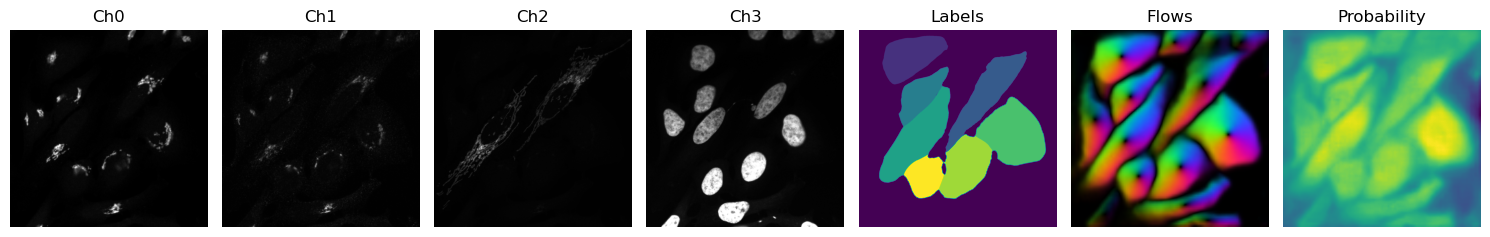

In [ ]:
import matplotlib.pyplot as plt
from cellpose import models

# Get the pretrained model
model = models.Cellpose(gpu=False, model_type='cyto2')

# To segment the cells in the image, we use channels 2 (mitochondria) and 3 (nuclei) for guidance. 


mask, flows, diams = model.eval(
    img,                    # Input image (can be 2D, 3D, or a batch of images)
    channels=[2, 3],        # Specifies the channels to use:
                            #   - [2, 3] means:
                            #       channel 2 → nuclear or cytoplasmic marker (e.g. for segmentation guidance)
                            #       channel 3 → optional auxiliary marker (e.g. nuclear or membrane)
                            #   - The model will use these two channels as input
    diameter=400,           # Expected object diameter in pixels
                            #   - Used to scale image internally for better model performance
                            #   - If too small or too large, it may affect segmentation accuracy
    cellprob_threshold=1.0  # Threshold applied to the "cell probability" output from the model
                            #   - Higher values make segmentation stricter (fewer false positives)
                            #   - Typical range is 0 to 1; 
)
# Outputs:
"masks (label image of segmented objects): np.ndarray"
"flows (intermediate outputs including predicted flows and probabilities): np.ndarray of shape (3, H, W)"
"flows[0, :, :] = horizontal (X) component of flow field"
"flows[1, :, :] = vertical (Y) component of flow field"
"flows[2, :, :] = cell probability map"
"diams (estimated object diameter): float or array"
"Used if diameter is set to 'auto', or to report the effective scale used."

# Display the results
fig, ax = plt.subplots(1,7, figsize=(15,5))
for k in range(4):
    ax[k].imshow(img[k], cmap='gray')
    ax[k].set_axis_off()
    ax[k].set_title('Ch'+str(k))
ax[4].imshow(mask)
ax[4].set_axis_off()
ax[4].set_title('Labels')
ax[5].imshow(flows[0])
ax[5].set_axis_off()
ax[5].set_title('Flows')
ax[6].imshow(flows[2])
ax[6].set_axis_off()
ax[6].set_title('Cell Probability')
fig.tight_layout()

## Regions properties 

In [7]:
from skimage import measure

props = measure.regionprops(mask)

## Using an interactive display
We will use the module 'interact' to view each labelled segmented region and observe if the segmentation was done as we expected it 

In [ ]:
from ipywidgets import interact
import numpy as np

def displayf(label):
    p = props[label]
    single_mask = np.zeros(img.shape[-2:])
    single_mask[p.coords[:,0], p.coords[:,1]] = 1
    
    plt.imshow(img[2,:,:].squeeze(), cmap='hot') # mitochondria
    plt.imshow(img[3,:,:].squeeze(), alpha=0.5 , cmap='grey') # nuclei
    plt.imshow(single_mask, alpha=0.2)

    return 

interact(displayf, label=(0, len(props)-1, 1)) # min, max, step


interactive(children=(IntSlider(value=3, description='label', max=6), Output()), _dom_classes=('widget-interac…

<function __main__.displayf(label)>

<div class="alert alert-success">

#### Exercise       

The cell segmentation was obtained after setting the parameters: diameter to 400 pixels and cellprob_threshold = 1.0. <br>
Observe the segmented regions change if you change the diameter or the cellprob_threshold.    
</div>

## Measure the colocalization coefficient 

The Pearson's correlation coefficient (PCC) is widely used to quantify the colocalization of one object $A$ into another object $B$. It can be calculated using the following formula [1]:

$$\text{PCC} = \frac{\sum_i\left( A_i - A_{aver} \right) \cdot \left( B_i - B_{aver} \right)}{\sqrt{\left[ \sum_i \left( A_i - A_{aver} \right)^2 \cdot \sum_i \left( B_i - B_{aver} \right)^2 \right]}}$$

$A$: cargo protein with $A_i$ being the intensity at pixel $i$ and $A_{aver}$ the average value intensity \
$B$: organelles (mitochondria or Golgi) with $B_i$ being the intensity at pixel $i$ and $B_{aver}$ the average value intensity

PCC values range from -1 to 1. We will use the function pearsonr from the scipy.stats module to compute it. We will calculate the PCC between the organelles: mitochondria or Golgi, and the cargo protein to quantify how much cargo relocates to each corresponding organelle for a given treatement done on the cell. We will observe how different the PCC values are in high presence (transfected) and low presence (not transfected) of mitochondria in each cell respectively. <br>

We will apply the following notations:
- PCC1: PCC between the cargo protein and Golgi 
- PCC2: PCC between the cargo protein and mitochondria

Source [1]: Manders, E.M., Verbeek, F.J. and Aten, J.A., 1993. Measurement of co‐localization of objects in dual‐colour confocal images. Journal of microscopy, 169(3), pp.375-382.

In [ ]:
import scipy.stats
import pandas as pd


ColCoeff = []  # List to store Pearson correlation results and associated measurements for each object
intensity_threshold = 1e6  # Threshold to determine whether a cell is considered "transfected"

# Loop through each object in the regionprops list
for p in props:
    # Extract intensity values for each channel at the coordinates of the current object (labelled region)
    ch00 = img[0,:,:].squeeze()[p.coords[:,0], p.coords[:,1]]  # Channel 0: Golgi marker
    ch01 = img[1,:,:].squeeze()[p.coords[:,0], p.coords[:,1]]  # Channel 1: Cargo protein
    ch02 = img[2,:,:].squeeze()[p.coords[:,0], p.coords[:,1]]  # Channel 2: Mitochondria

    # Compute the total intensity of mitochondria in this object
    sum_mitochondria = ch02.sum()
    # Determine transfection condition based on mitochondria intensity
    if sum_mitochondria >= intensity_threshold:
        c = 'Transfected'
    else:
        c = 'Not transfected'

    # Compute Pearson correlation coefficient between:
    # - Golgi and Cargo protein (PCC1)
    # - Cargo protein and Mitochondria (PCC2)
    [r1, pv] = scipy.stats.pearsonr(ch00, ch01)
    [r2, pv] = scipy.stats.pearsonr(ch01, ch02)

    # Append results as a dictionary to the list
    ColCoeff.append({
        'label': p.label,                          # Object label
        'PCC1': r1,                                # Pearson correlation: Golgi vs Cargo
        'PCC2': r2,                                # Pearson correlation: Cargo vs Mitochondria
        'Area': p.area,                            # Area of the object
        'Integrated intensity': sum_mitochondria,  # Total mitochondria intensity
        'Condition': c                             # Transfection status
    })

# Convert the list of dictionaries to a pandas DataFrame for easier analysis
ColCoeff = pd.DataFrame.from_records(ColCoeff)
# Display the DataFrame
ColCoeff

## Statistical analysis
We would like to analyze the relocation of the cargo to the Golgi: to compare the PCC between the cargo and Golgi signal (PCC1) in two groups of cells: transfected (with high mitochondrial content) and non-transfected (with low mitochondrial content). 

### P-value
The p-value is obtained from a statistical test (Mann–Whitney U test) comparing PCC1 values between transfected and non-transfected cells. It reflects the probability of observing such a difference by chance if there were no actual relationship between mitochondrial content and cargo–Golgi colocalization. A smaller p-value indicates stronger evidence that the two groups differ in terms of PCC1.

In [ ]:
# Filter the DataFrame to separate objects based on their transfection condition
grp1 = ColCoeff[ColCoeff['Condition'] == 'Transfected']       # Subset of transfected objects
grp2 = ColCoeff[ColCoeff['Condition'] == 'Not transfected']   # Subset of non-transfected objects

# Perform a Mann-Whitney U test (non-parametric test) to compare the PCC1 values
# between transfected and non-transfected groups
pvalue = scipy.stats.mannwhitneyu(grp1['PCC1'], grp2['PCC1'])

# Print the resulting p-value (and test statistic) to evaluate if there's a significant difference
print(pvalue)


## Display of the result
Display the PCC values, annotate the p-value and save the result into pdf file

In [ ]:
# Import seaborn for plotting and statannotations for statistical annotation on plots
import seaborn as sns
from statannotations.Annotator import Annotator

# Define the two experimental conditions in desired plotting order
conditions_list = ['Not transfected', 'Transfected']

# Create a dictionary of plotting parameters for reuse (cleaner code)
plotting_parameters = {
    'data':    ColCoeff,          # DataFrame containing PCC values and metadata
    'x':       'Condition',       # X-axis will show the condition (transfection status)
    'y':       'PCC1',            # Y-axis will show the PCC between Golgi and Cargo
    'order':   conditions_list,   # Force consistent order of conditions
}

# Create a violin plot showing the distribution of PCC1 in each condition
ax = sns.violinplot(**plotting_parameters, color="0.9")
# Overlay individual data points using a stripplot (adds visibility to distribution)
sns.stripplot(**plotting_parameters, jitter=True, size=2)

# Set up the Annotator to add statistical test result on the plot
annotator = Annotator(ax, tuple([conditions_list]), **plotting_parameters)
# Provide the p-value from the Mann-Whitney U test
annotator.set_pvalues([pvalue.pvalue])
# Configure annotation display: show p-value outside the plot area
annotator.configure(loc='outside')
# Draw the annotation on the plot
annotator.annotate()

# Set the title of the plot with red text and slightly adjusted vertical placement
ax.set_title('Relocation of the \nCargo to the Golgi', 
             y=1.0, pad=-10, c='red', horizontalalignment='center')

# Save the figure to PDF with tight layout to avoid cutting off elements
plt.savefig('PCC_Cargo_to_Golgi.pdf', format="pdf", bbox_inches="tight")


<div class="alert alert-success">

#### Exercise       

Display the result of the statistical analysis which corresponds to the relocation of cargo to the mitochondria. <br>
Make sure the title of the figure and the name under which the figure will be saved are updated.
   
</div>

<div class="alert alert-success">

#### Human in the loop       

python3 -m cellpose or cellpose  <br>
    
</div>

# Train in a notebook 
We can train multiple images with corresponding masks using GUI (open an image in that folder); but we can only re-train the CellPose pretrained models this way, like “cyto3” (feel like you can only re-train a few times of cyto3 and it does not get any better); if to re-train a custom model, we need to use terminal in terminal or in a notebook as follows:

In [ ]:
from cellpose import io, models, train
io.logger_setup()

output = io.load_train_test_data(train_dir, test_dir, image_filter="_img",
                                mask_filter="_masks", look_one_level_down=False)
images, labels, image_names, test_images, test_labels, image_names_test = output

# e.g. retrain a Cellpose modelmodel = models.CellposeModel(model_type="cyto3")

model_path, train_losses, test_losses = train.train_seg(model.net,
                            train_data=images, train_labels=labels,
                            channels=[1,2], normalize=True,
                            test_data=test_images, test_labels=test_labels,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=100, model_name="my_new_model")